In [ ]:
# !pip install pysam
# !pip install pyfaidx
# !pip install bionumpy
# !pip install biopython
# !pip install scikit-fuzzy
# pip install kaleido
# pip install dask
# !pip install hdbscan
#import pysam
#from Bio import SeqIO
# import bionumpy as bnp
# import dask.dataframe as dd
# from bionumpy.io.delimited_buffers import DelimitedBuffer
# from bionumpy.bnpdataclass import bnpdataclass
#from pyfaidx import Fasta
# import shutil

In [1]:

import tarfile
import pandas as pd
import numpy as np

import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# import torch_xla
# import torch_xla.core.xla_model as xm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.cluster import DBSCAN
import gc
from tqdm import tqdm
import time
from itertools import product
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
#import hdbscan
#import skfuzzy
#from skfuzzy import cmeans
from sklearn.preprocessing import StandardScaler
#from mpl_toolkits.mplot3d import Axes3D
#import plotly.graph_objects as go
from torch.cuda.amp import GradScaler, autocast

In [ ]:
# # Разархивируем файл с мутациями
# tar_file_path = '/content/drive/MyDrive/Cosmic_GenomeScreensMutant_VcfNormal_v101_GRCh38.tar'
# with tarfile.open(tar_file_path, 'r') as tar:
#   tar.extractall('/content/drive/MyDrive')
#   print(f'Extracted file: {tar.getnames()}')

In [ ]:
# # Парсим файл с мутациями
# vcf_file_path = '/content/drive/MyDrive/Cosmic_GenomeScreensMutant_Normal_v101_GRCh38.vcf.gz'
# # row_limit = 20000000
# # data = []
# # Open the VCF file
# with pysam.VariantFile(vcf_file_path, "r") as vcf_file:
#     for row_count, record in enumerate(vcf_file.fetch()):
#         data.append({
#             'Chromosome': record.chrom,
#             'Position': record.pos,
#             'ID': record.id,
#             'Reference': record.ref      
#             })
#         # if row_count + 1 >= row_limit:
#         #     break
# df = pd.DataFrame(data)
# # Extract INFO fields into separate columns
# # info_df = df['Info'].apply(pd.Series)
# # df = pd.concat([df.drop(columns=['Info']), info_df], axis=1)
# print(df.head())  # Preview the first rows

In [ ]:
# Сохраним полученный файл с мутациями
#df.to_csv('Cosmic_df.csv', index=False)

In [ ]:
# Разархивируем полногеномный файл человека если формат gzip
# with gzip.open(' ', 'rt') as file:
#   with open("GCF_000001405.40_GRCh38.p14_genomic.fna", 'w') as file_out:
#     shutil.copyfileobj(file, file_out)

In [ ]:
# chunk_size = 5000000
# chunks = []
# for chunk in pd.read_csv('/kaggle/input/cosmic-completetargetedscreensmutant/Cosmic_CompleteTargetedScreensMutant_v101_GRCh38.tsv/Cosmic_CompleteTargetedScreensMutant_v101_GRCh38.tsv', 
#                          sep = '\t',
#                          usecols=['TRANSCRIPT_ACCESSION', 'COSMIC_SAMPLE_ID', 'COSMIC_PHENOTYPE_ID', 
#                                   'GENOMIC_MUTATION_ID', 'MUTATION_CDS', 'MUTATION_DESCRIPTION', 
#                                   'MUTATION_ZYGOSITY', 'CHROMOSOME', 'STRAND', 'MUTATION_SOMATIC_STATUS', 
#                                   'POSITIVE_SCREEN'],
#                          chunksize=chunk_size):
#     chunks.append(chunk)
# targeted_screen = pd.concat(chunks, ignore_index=True)

In [ ]:
targeted_screen.to_csv('targeted_screen_mut.csv', index=False)

In [ ]:
# nan_percentage = targeted_screen.isna().mean() * 100
# print(nan_percentage)

In [ ]:
hallmarks = pd.read_csv('/kaggle/input/cosmic-data/Cosmic_CancerGeneCensusHallmarksOfCancer_v101_GRCh38.tsv', sep='\t')
classification = pd.read_csv('/kaggle/input/cosmic-data/Cosmic_Classification_v101_GRCh38.tsv', sep='\t')
transcripts = pd.read_csv('/kaggle/input/cosmic-data/Cosmic_Transcripts_v101_GRCh38.tsv', sep='\t')

In [ ]:
# transcripts

In [ ]:
# # Парсим файл генома человека
fna_file_path = "/kaggle/input/gcf-000001405-40-grch38-p14-genomic-fna-gz/GCF_000001405.40_GRCh38.p14_genomic.fna"
# with open(fna_file_path, "r") as fna_file:
#     for record in SeqIO.parse(fna_file, "fasta"):
#         print(f"ID: {record.id}")
#         print(f"Description: {record.description}")
#         print(f"Sequence Length: {len(record.seq)}")
#         print(f"First 100 Bases: {record.seq[:100]}")
#         print("-" * 50)

In [ ]:
# Проверим совпадения позиций в двух датасетах
target_position = 65797
target_chromosome = 'NC_000001.11'
for record in SeqIO.parse(fna_file_path, "fasta"):
    if record.id == 'NC_000001.11':  # Проверяем идентификатор хромосомы
        # Позиции в Biopython индексируются с нуля, поэтому вычитаем 1
        nucleotide = record.seq[target_position-1]
        print(f"Нуклеотид на позиции {target_position} в хромосоме {target_chromosome}: {nucleotide}")
        break
else:
    print(f"Хромосома {target_chromosome} не найдена в файле.")

In [ ]:
# Создадим словарь для соответствия названий хромосом и их идентификаторов в полногеномнике
chromosome_dict = {
    1: 'NC_000001.11',
    #2: 'NC_000002.12',
    3: 'NC_000003.12',
    4: 'NC_000004.12',
    5: 'NC_000005.10',
    6: 'NC_000006.12',
    7: 'NC_000007.14',
    8: 'NC_000008.11',
    9: 'NC_000009.12',
    10: 'NC_000010.11',
    11: 'NC_000011.10',
    12: 'NC_000012.12',
    13: 'NC_000013.11',
    14: 'NC_000014.9',
    15: 'NC_000015.10',
    16: 'NC_000016.10',
    17: 'NC_000017.11',
    18: 'NC_000018.10',
    19: 'NC_000019.10',
    20: 'NC_000020.11',
    21: 'NC_000021.9',
    22: 'NC_000022.11',
    'X': 'NC_000023.11',
    'Y': 'NC_000024.10'
}

In [ ]:
# # Читаем референсный геном и сохраняем его в словарь
def load_primary_assembly(fna_file_path):
    genome = {}
    for record in SeqIO.parse(fna_file_path, "fasta"):
        if "Primary Assembly" in record.description and "unlocalized" not in record.description and "unplaced" not in record.description:
            genome[record.id] = record.seq
    return genome

# Загружаем только primary assembly
hg38_genome = load_primary_assembly("/kaggle/input/gcf-000001405-40-grch38-p14-genomic-fna-gz/GCF_000001405.40_GRCh38.p14_genomic.fna")

# Загружаем датасет мутаций
# mutation_dataset = pd.read_csv('/kaggle/input/cosmic-df-csv/Cosmic_df.csv')

# Проверка загруженных данных
print(f"Число загруженных хромосом: {len(hg38_genome)}")
for chrom in list(hg38_genome.keys())[:5]:  # Выведем первые 5 хромосом
    print(f"ID: {chrom}, Длина: {len(hg38_genome[chrom])}")

In [ ]:
# def get_flanking_seq(row, genome, flank_size=100):
#     chrom_id = chromosome_dict.get(row['Chromosome'])
#     if not chrom_id:
#         return None  # Если хромосома не найдена в словаре
#     position = row['Position']
#     try:
#         seq = genome[chrom_id]  # Получаем последовательность хромосомы
#         start = max(0, position - flank_size - 1)  # Начальная позиция (учитываем границы)
#         end = position + flank_size  # Конечная позиция
#         flanking_seq = seq[start:end]  # Вырезаем фланкирующую последовательность
#         return str(flanking_seq)  # Преобразуем в строку
#     except KeyError:
#         return None  # Если хромосома отсутствует в референсе
# # Применяем функцию к каждой строке файла с мутациями
# mutation_dataset['flanking_seq'] = mutation_dataset.apply(
#     lambda row: get_flanking_seq(row, hg38_genome), axis=1
# )

In [ ]:
mutation_dataset['flanking_seq'] = mutation_dataset['flanking_seq'].apply(lambda seq: seq.upper() if pd.notnull(seq) else seq)

In [ ]:
mutation_dataset.to_csv('mut_flank.csv', index=False)

In [ ]:
mutation_dataset = mutation_dataset[mutation_dataset['Chromosome'] != 'MT']
mutation_dataset = mutation_dataset[mutation_dataset['Chromosome'] != 2]

In [ ]:
mutation_dataset = mutation_dataset.dropna()

In [ ]:
mutation_dataset = mutation_dataset[mutation_dataset['Reference'].apply(len) < 21]

In [ ]:

mutation_dataset = mutation_dataset[mutation_dataset['Chromosome'] != 3]

In [ ]:
max_len = mutation_dataset['Reference'].apply(len).max()
max_len

In [ ]:
chromosome_dict = {str(key): value for key, value in chromosome_dict.items()}

In [ ]:
# chromosome_dict

In [ ]:
# mutation_dataset = pd.read_csv('/kaggle/input/mut-flank-csv/mut_flank.csv')
# mutation_dataset = mutation_dataset.dropna(subset=['flanking_seq'])

# # Вторая хромосома не вошла в словарь хромосом, потому фланкирующие последовательности для нее не отобраны
# # Выбрасываем строки содержащие в 4 колонке Nan - это все значеения для 2 хромосомы

# chromosome_counts = mutation_dataset['Chromosome'].value_counts(normalize=True)
# # chromosome_counts

In [ ]:
# chromosome_counts

In [ ]:
chromosome_lengths = {
    chrom_key: len(hg38_genome[chrom_value]) 
    for chrom_key, chrom_value in chromosome_dict.items() 
    if chrom_value in hg38_genome.keys()  # Убедимся, что хромосома существует в genome
 }
# chromosome_lengths = {
#     str(chrom_key): chrom_length 
#     for chrom_key, chrom_length in chromosome_lengths.items()
# }
# # Проверим результат
print(chromosome_lengths)

In [ ]:
# chrom_length = chromosome_lengths[chrom]

### <span style="color: blue;">Создаем список последовательностей нуклеотидов из референсного генома, выбрав такие участки, которые не перекрываются с позициями из датасета COSMIC.</span>


In [ ]:
from tqdm import tqdm

forbidden_regions = {}

# Группируем данные по хромосомам
for chrom, group in tqdm(mutation_dataset.groupby('Chromosome')):
    forbidden_regions[chrom] = [(pos - 200, pos + 200) for pos in group['Position']]


In [ ]:

def get_free_intervals(chrom, forbidden_regions, chrom_length, min_length=201):
    """
    Получает список свободных интервалов на хромосоме, которые не перекрывают запрещенные регионы
    и имеют длину не менее min_length.
    """
    # Сортируем запрещенные регионы по начальной позиции
    forbidden_regions_sorted = sorted(forbidden_regions, key=lambda x: x[0])
    
    # Инициализируем список свободных интервалов
    free_intervals = []
    
    # Начальный интервал от 0 до начала первого запрещенного региона
    prev_end = 0
    
    for start, end in forbidden_regions_sorted:
        # Если текущий запрещенный регион не перекрывает предыдущий, то мы находим свободный интервал
        if start > prev_end:
            free_intervals.append((prev_end, start))
        prev_end = max(prev_end, end)
    
    # Добавляем последний интервал от конца последнего запрещенного региона до конца хромосомы
    if prev_end < chrom_length:
        free_intervals.append((prev_end, chrom_length))
    
    # Фильтруем свободные интервалы по минимальной длине
    free_intervals = [interval for interval in free_intervals if interval[1] - interval[0] >= min_length]
    
    return free_intervals

# Статистика для первой хромосомы
chrom = 1  # Пример для хромосомы 1
chrom_length = chromosome_lengths.get(chrom)  # Получаем длину хромосомы
forbidden = forbidden_regions.get(chrom, [])  # Получаем список запрещенных регионов

# Получаем свободные интервалы
free_intervals = get_free_intervals(chrom, forbidden, chrom_length)

# Выводим статистику
print(f"Хромосома {chrom}, длина: {chrom_length}")
print(f"Количество свободных интервалов длиной не менее 201 базы: {len(free_intervals)}")

# Проверим количество разрешенных регионов для каждой хромосомы
for chrom in allowed_regions:
    print(f"Хромосома {chrom}: {len(allowed_regions[chrom])} разрешенных интервалов")


In [ ]:
# Создаем словарь для разрешенных регионов
allowed_regions = {}

# Группируем данные по хромосомам
for chrom, group in tqdm(mutation_dataset.groupby('Chromosome')):
    forbidden = forbidden_regions.get(chrom, [])
    chrom_length = chromosome_lengths.get(chrom)

    # Находим все возможные свободные участки (разрешенные регионы) между запрещенными регионами
    allowed = []
    prev_end = 0
    for start, end in sorted(forbidden):
        if start > prev_end:  # Если есть промежуток между запрещенными регионами
            allowed.append((prev_end, start))  # Добавляем свободный интервал
        prev_end = max(prev_end, end)  # Обновляем конец последнего запрещенного региона

    # Добавляем оставшийся участок после последнего запрещенного региона, если таковой имеется
    if prev_end < chrom_length:
        allowed.append((prev_end, chrom_length))
    
    allowed_regions[chrom] = allowed


In [ ]:
# Сгенерируем последовательности нуклеотидов из разрешенных участков хромосом, которые не перекрываются 
# с запрещенными - позиции неклоетидных замен из датасета Cosmic +-200пн

random_sites = []
total_samples = 1_000_000
nan_warning_shown = False

with tqdm(total=total_samples, desc="Generating random sites", ncols=100) as pbar:
    while len(random_sites) < total_samples:
        for chrom, proportion in chromosome_counts.items():
            hg38_key = chromosome_dict.get(chrom)
            if hg38_key not in hg38_genome:
                continue

            num_samples = int(proportion * total_samples)
            forbidden = forbidden_regions.get(chrom, [])
            allowed = allowed_regions.get(chrom, [])
            
            for _ in range(num_samples):
                max_attempts = 100
                attempts = 0
                while attempts < max_attempts:
                    # Выбираем случайный разрешенный регион
                    start_pos, end_pos = random.choice(allowed)
                    if end_pos - start_pos < 201:
                        continue  # Пропускаем, если интервал слишком короткий
                    
                    # Генерируем случайный участок внутри разрешенного региона
                    start_pos = random.randint(start_pos, end_pos - 201)
                    end_pos = start_pos + 201

                    sequence = hg38_genome[hg38_key][start_pos:end_pos].upper()

                    # Проверка на 'N' в последовательности
                    if 'N' in sequence:
                        attempts += 1
                        continue
                    
                    # Проверка на NaN
                    if pd.isna(sequence):
                        if not nan_warning_shown:
                            print(f"⚠️ ВНИМАНИЕ: Найдено NaN в последовательности на хромосоме {chrom}, позиции {start_pos}-{end_pos}")
                            nan_warning_shown = True
                        attempts += 1
                        continue

                    # Добавление валидного участка
                    random_sites.append({'Chromosome': chrom, 'Start': start_pos, 'End': end_pos, 'Sequence': sequence})
                    break

                if attempts >= max_attempts:
                    print(f"Не удалось сгенерировать участок для хромосомы {chrom} после {max_attempts} попыток.")

            pbar.update(len(random_sites) - pbar.n)

# Создаем DataFrame
random_seq = pd.DataFrame(random_sites)

print(f"✅ Сгенерировано {len(random_seq)} случайных участков.")

In [ ]:
# random_seq['Sequence'] = random_seq['Sequence'].apply(lambda x: "".join(x))
# random_seq["Position"] = (random_seq["Start"] + random_seq["End"]) // 2
# random_seq["ID"] = 'REFA00000001'
# random_seq = random_seq.drop(columns = ['Start', 'End'])
# random_seq = random_seq[["Chromosome", "Position", "ID", "Reference", "Sequence"]]
# random_seq.rename(columns = {'Sequence':'flanking_seq'}, inplace=True)

In [ ]:
random_seq.to_csv('random_sequence.csv', index=False)

In [ ]:
df = pd.concat([random_seq, mut_dataset], ignore_index=True)
# Добавляем лейблы для референсных последовательнотей и Cosmic данных как 0 и 1 
df['label'] = df['Reference'].apply(lambda x: 0 if x == 'R' else 1)

In [ ]:
df.to_csv('cosimic_reference_data.csv', index=False)

In [ ]:
# # Создаем датасет с 3 нужными колонками "COSMIC_SAMPLE_ID", "COSMIC_PHENOTYPE_ID", "GENOMIC_MUTATION_ID"
# # из файла со всеми однонуклеотидными мутациями и сохраняем в отлельный датасет
# # Для анализа кластеров полученных после автоэнкодера

# input_file = "/kaggle/input/cosmic-genomescreensmutant-tsv-v101-grch38-tar/Cosmic_GenomeScreensMutant_v101_GRCh38.tsv/Cosmic_GenomeScreensMutant_v101_GRCh38.tsv"
# output_file = "phenotype_id.tsv"
# columns_to_extract = ["COSMIC_SAMPLE_ID", "COSMIC_PHENOTYPE_ID", "GENOMIC_MUTATION_ID"]  # Заменить на реальные названия

# chunksize = 5000000

# with pd.read_csv(input_file, sep='\t', chunksize=chunksize, usecols=columns_to_extract) as reader:
#     for i, chunk in enumerate(reader):
#         chunk.to_csv(output_file, sep='\t', mode='a', index=False, header=(i == 0))


## **NN**

In [2]:
df = pd.read_csv('/kaggle/input/cos-and-ref-dataset/cos_and_ref.csv')

<ipython-input-2-c11db2390787>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/cos-and-ref-dataset/cos_and_ref.csv')


In [3]:
# Группировка по flanking_seq и проверка количества уникальных label
duplicates = df.groupby("flanking_seq")["label"].nunique()

# Вывод только тех последовательностей, которые встречаются в обоих лейблах
common_seqs = duplicates[duplicates > 1].index

print(f"Найдено {len(common_seqs)} последовательностей, встречающихся в обоих классах.")

# Вывести примеры
print(df[df["flanking_seq"].isin(common_seqs)].sort_values("flanking_seq"))

# Фильтруем данные: оставляем только flanking_seq, которые встречаются в обоих классах
df_filtered = df[df["flanking_seq"].isin(common_seqs)]

# Удаляем строки, где label == 0, но только для найденных общих последовательностей
df_filtered = df_filtered[df_filtered["label"] != 0]

# Обновляем исходный DataFrame (убираем исходные строки и добавляем отфильтрованные обратно)
df = pd.concat([df[~df["flanking_seq"].isin(common_seqs)], df_filtered])

Найдено 70 последовательностей, встречающихся в обоих классах.
        Chromosome   Position             ID Reference  \
2468731          2  171449885  COSV107402764         G   
910677          20    3517619   REFA00000001         R   
418804           4   21164742   REFA00000001         R   
2503243          2  137353923   COSV55703452         C   
1387284          5   70942833   REFA00000001         R   
...            ...        ...            ...       ...   
2029320          1  174844843   COSV52309487         C   
626003           8  105367342   REFA00000001         R   
2250424          1  174844843   COSV52309487         C   
1402868          5    7604770   REFA00000001         R   
2566535          2  148430370  COSV108247092         T   

                                              flanking_seq  label  
2468731  AAAATTTTTGGGAGGCCAAGGAGGGTGGATCACCTGAGGTCACAAG...      1  
910677   AAAATTTTTGGGAGGCCAAGGAGGGTGGATCACCTGAGGTCACAAG...      0  
418804   AAACACATGAAGAAATGCTCATCATCA

In [15]:
# Делаем выборку наименьшего класса 
min_sample_size = df['label'].value_counts().min()
# Берем половину от меньшего класса, т.к итоговый датасет также будет уменьшаться вдвое
sample_size  = min_sample_size //2
# Отбираем одинаковок количество примеров из обоих классов
df = df.groupby('label').apply(lambda x:x.sample(n = sample_size , random_state=33))
df = df.reset_index(drop=True)
df['label'].value_counts()

<bound method IndexOpsMixin.value_counts of 0         0
1         0
2         0
3         0
4         0
         ..
999941    1
999942    1
999943    1
999944    1
999945    1
Name: label, Length: 999946, dtype: int64>

In [ ]:
# valid_nucleotides = {'A', 'C', 'G', 'T'}
# df = df[~df['flanking_seq'].apply(lambda seq: any(nuc not in valid_nucleotides for nuc in seq))]
# unique_chars = set("".join(df['flanking_seq']))
# print(unique_chars)

In [ ]:
# #df_test = df[df['Chromosome'].isin([17, 13])]
# # df = df.groupby('Chromosome').sample(frac=0.3, random_state=42)
# # df['flanking_seq'] = df['flanking_seq'].str.slice(70, -70)
# df['flanking_seq'] = df['flanking_seq'].str[:-1]
# # df['flanking_seq'] = df['flanking_seq'].str.slice(85, -85)
# max = df['flanking_seq'].apply(len).max()
# max

In [ ]:
# # Filter df using updated filtered_pheno
# df_filtered = df[df['ID'].isin(filtered_pheno['GENOMIC_MUTATION_ID'])].merge(
#     filtered_pheno[['GENOMIC_MUTATION_ID', 'PRIMARY_HISTOLOGY']], 
#     left_on='ID', right_on='GENOMIC_MUTATION_ID', how='left'
# ).drop(columns=['GENOMIC_MUTATION_ID'])

# # Reduce carcinoma cases by 10x
# df_filtered = pd.concat([
#     df_filtered[df_filtered['PRIMARY_HISTOLOGY'] == 'carcinoma'].sample(frac=0.1, random_state=98),
#     df_filtered[df_filtered['PRIMARY_HISTOLOGY'] != 'carcinoma']
# ], ignore_index=True)
# df_filtered['PRIMARY_HISTOLOGY'].value_counts()

In [17]:
X = df['flanking_seq']
y = df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 44, shuffle=True)

In [18]:
# X_train = X_train.groupby('Chromosome').sample(frac=0.1, random_state=39)
#X_valid = X_valid.groupby('Chromosome').sample(frac=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valid, y_valid, test_size = 0.1, random_state = 46)

In [19]:
nucleotide_to_index = {
    'A': 0,
    'C': 1,
    'G': 2,
    'T': 3
}

In [20]:
# Обуаемый эмбеддинг
def sequence_to_indices(sequence):
    try:
        indices = np.array(list(sequence))  # Преобразуем строку в массив символов
        return np.vectorize(nucleotide_to_index.get)(indices)  # Применяем словарь для преобразования символов в индексы
    except Exception as e:
        # Выводим отладочную информацию
        print(f"Ошибка в последовательности: {sequence}")
        raise e  # Повторно выбрасываем исключение для диагностики
tqdm.pandas()
X_train = X_train.progress_apply(sequence_to_indices)
X_val = X_val.progress_apply(sequence_to_indices)
X_test = X_test.progress_apply(sequence_to_indices)

100%|██████████| 19999/19999 [00:01<00:00, 16002.90it/s]


In [ ]:
# # Функция для генерации последовательности длиной 201 для каждого из символов
# def generate_sequence(base, length=201):
#     return base * (length // len(base)) + base[:length % len(base)]

# # Генерация 
# num_sequences = 10000
# bases = ['A', 'C', 'T', 'G']
# sequences = []

# for _ in range(num_sequences):
#     for base in bases:
#         sequences.append(generate_sequence(base))

# # Печать первых 5 последовательностей для проверки
# for seq in sequences[:5]:
#     print(seq)

# sequences_series = pd.Series(sequences)

In [ ]:
# # Функция для генерации случайной последовательности длиной 200 с вариациями
# def generate_random_sequence(length=200, variation_rate=0.1):
#     bases = ['A', 'C', 'T', 'G']
#     sequence = [random.choice(bases) for _ in range(length)]
#     num_variations = int(length * variation_rate)

#     for _ in range(num_variations):
#         position = random.randint(0, length - 1)
#         new_base = random.choice([b for b in bases if b != sequence[position]])
#         sequence[position] = new_base
    
#     return ''.join(sequence)

# # Генерация cлучайных последовательностей с вариациями
# num_sequences = 10000
# random_sequences = []

# for _ in range(num_sequences):
#     sequence = generate_random_sequence()
#     random_sequences.append(sequence)

# # Печать первых 5 случайных последовательностей для проверки
# for seq in sequences[:5]:
#     print(seq)


In [ ]:
# import random

# # Функция для генерации случайной последовательности с заданным GC-составом
# def generate_sequence_with_gc_content(length=200, gc_content=0.6):
#     bases_gc = ['G', 'C']
#     bases_at = ['A', 'T']
    
#     # Определяем количество нуклеотидов GC и AT
#     num_gc = int(length * gc_content)
#     num_at = length - num_gc

#     # Генерация частей последовательности
#     gc_sequence = [random.choice(bases_gc) for _ in range(num_gc)]
#     at_sequence = [random.choice(bases_at) for _ in range(num_at)]

#     # Перемешиваем и создаем полную последовательность
#     full_sequence = gc_sequence + at_sequence
#     random.shuffle(full_sequence)

#     return ''.join(full_sequence)

# # Функция для генерации последовательностей с разными GC-составами
# def generate_sequences_with_varied_gc(length=200, gc_contents=[0.6, 0.4], num_sequences=10000):
#     sequences = []
#     for _ in range(num_sequences):
#         gc_content = random.choice(gc_contents)  # Выбираем случайный GC-состав из списка
#         sequence = generate_sequence_with_gc_content(length, gc_content)
#         sequences.append(sequence)
    
#     return sequences

# # Генерация 10 000 последовательностей с GC-составом 60% и 40%
# num_sequences = 10000
# gc_contents = [0.6, 0.4]
# random_sequences = generate_sequences_with_varied_gc(length=200, gc_contents=gc_contents, num_sequences=num_sequences)
# random_sequences = pd.DataFrame(random_sequences)
# # Печать первых 5 последовательностей для проверки
# for seq in random_sequences[:5]:
#     print(seq)
# random_sequences['indexed_flanking_seq'] = random_sequences[0].apply(sequence_to_indices)

In [ ]:
# def sequence_to_indices(sequence):
#     # Define a dictionary mapping nucleotides to indices
#     nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
#     # Convert the sequence to a list of indices
#     indices = [nucleotide_to_index[nucleotide] for nucleotide in sequence]
    
#     return indices

# # Apply the function to the DataFrame
# random_sequences['indexed_flanking_seq'] = random_sequences[0].apply(sequence_to_indices)


In [ ]:
# Embedding by k mers
# Define k sizes
k_sizes = [3]  # You can extend this list for multiple k sizes

# Generate all possible k-mers with len k_size
all_kmers = [''.join(p) for k in k_sizes for p in product('ACGT', repeat=k)]

# Create k-mer to integer mapping
kmer_to_int = {kmer: idx for idx, kmer in enumerate(all_kmers)}

                     
# Function to generate k-mers from my sequence
def generate_variable_kmers(sequence, k_sizes):
   kmers = []
   for k in k_sizes:
       kmers.extend([''.join(sequence[i:i+k]) for i in range(len(sequence) - k + 1)])
   return kmers

# Function to encode k-mers using the predefined mapping
def integer_encode_variable_kmers(sequence, k_sizes, kmer_to_int):
   kmers = generate_variable_kmers(sequence, k_sizes)
   return [kmer_to_int[kmer] for kmer in kmers if kmer in kmer_to_int]

# Apply integer encoding to the flanking sequences
X_train['encoded_kmers'] = X_train['flanking_seq'].apply(lambda seq: integer_encode_variable_kmers(seq, k_sizes, kmer_to_int))
X_val['encoded_kmers'] = X_val['flanking_seq'].apply(lambda seq: integer_encode_variable_kmers(seq, k_sizes, kmer_to_int))
test_data['encoded_kmers'] = test_data['flanking_seq'].apply(lambda seq: integer_encode_variable_kmers(seq, k_sizes, kmer_to_int))
#print(X_train[['flanking_seq', 'encoded_kmers']])

In [21]:
X_train_array = np.stack(X_train.values)
X_val_array = np.stack(X_val.values)
X_test_array = np.stack(X_test.values)

In [34]:
nucleotide_dim = 4 #len(kmer_to_int)
embedding_dim = 12
input_length = 201
learning_rate = 0.002
num_classes = 2
batch_size = 128
num_epochs = 20

In [31]:
# Переводим в тензоры каждый набор данных X и y
X_train_tensor = torch.tensor(X_train_array, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_array, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создаем тензор датасеты для тренеровочной, валидационной и тестовой выборок
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Создаем даталоадеры для каждой выборки
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
class DNA_CNN(nn.Module):
    def __init__(self, input_length, batch_size, num_classes, embedding_dim, nucleotide_dim):
        super(DNA_CNN, self).__init__()
        # Эмбеддинг слой
        self.embedding = nn.Embedding(num_embeddings=nucleotide_dim, embedding_dim=embedding_dim)
        
        # Сверточные слои
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=156, kernel_size=5, padding=2)

        self.flatten = nn.Flatten()
        # Полносвязные слои
        self.fc1 = nn.Linear(156 * (input_length // 8), 100)
        self.fc2 = nn.Linear(100, num_classes)
        
        # Пулинг
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x):
        #print(f'Подается в embedding {x.shape}')
        x = self.embedding(x)
        #print(f'После embedding {x.shape}')
        x = x.transpose(1, 2)
        #print(f'После transpose {x.shape}')  
        x = self.pool(F.relu(self.conv1(x)))  # 1-й сверточный слой
        #print(f'После первой свертки {x.shape}')  
        x = self.pool(F.relu(self.conv2(x)))  # 2-й сверточный слой
        #print(f'После второй свертки {x.shape}')  
        x = self.pool(F.relu(self.conv3(x)))  # 3-й сверточный слой
        #print(f'После третьей свертки {x.shape}')  
        x = self.flatten(x)
        x = F.relu(self.fc1(x))  # Полносвязный слой
        #print(f'После первого полносвязного {x.shape}') 
        x = F.relu(self.fc2(x))
        #print(f'После второго полносвязного {x.shape}') 

        return x


model = DNA_CNN(input_length=201,batch_size=batch_size, nucleotide_dim=nucleotide_dim, embedding_dim=embedding_dim, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

-----------------------------------------------
Epoch 1
-----------------------------------------------
Train loss 0.6931520934675105, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


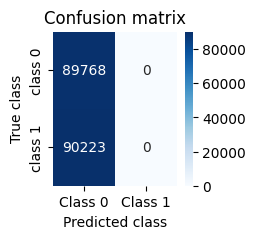

-----------------------------------------------
Epoch 2
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


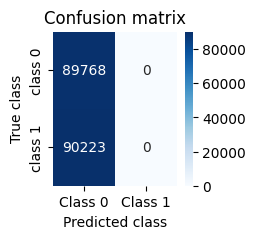

-----------------------------------------------
Epoch 3
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


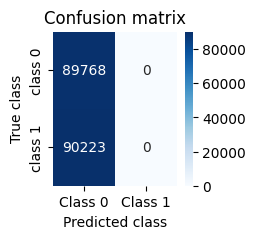

-----------------------------------------------
Epoch 4
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


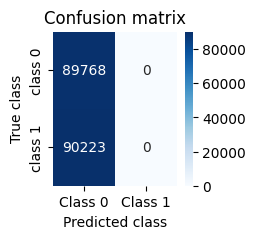

-----------------------------------------------
Epoch 5
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


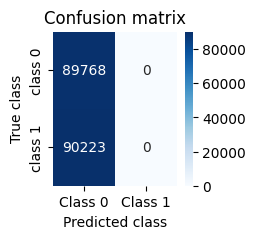

-----------------------------------------------
Epoch 6
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


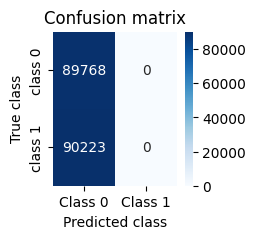

-----------------------------------------------
Epoch 7
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


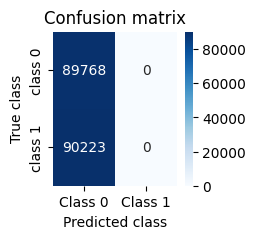

-----------------------------------------------
Epoch 8
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


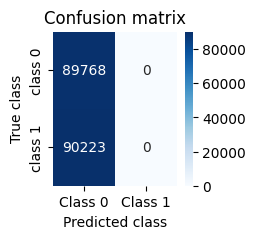

-----------------------------------------------
Epoch 9
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


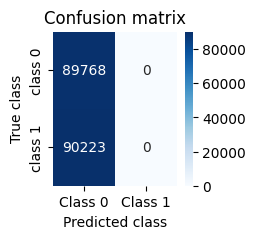

-----------------------------------------------
Epoch 10
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


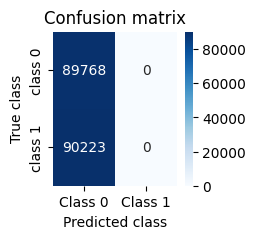

-----------------------------------------------
Epoch 11
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


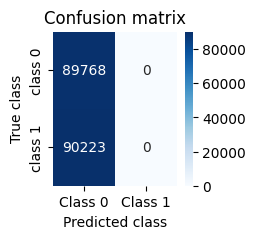

-----------------------------------------------
Epoch 12
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


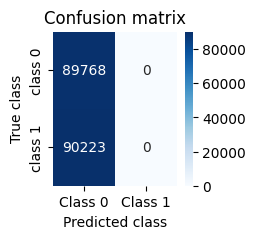

-----------------------------------------------
Epoch 13
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


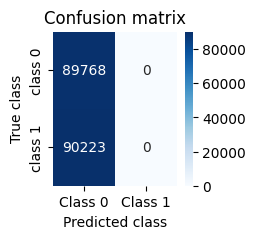

-----------------------------------------------
Epoch 14
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


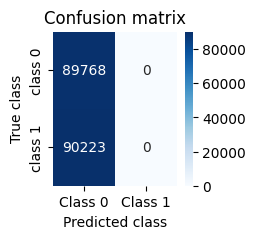

-----------------------------------------------
Epoch 15
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


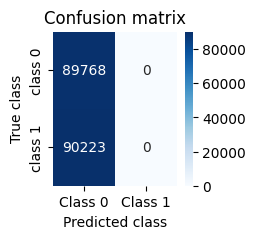

-----------------------------------------------
Epoch 16
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


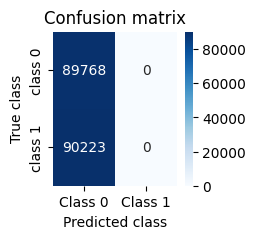

-----------------------------------------------
Epoch 17
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


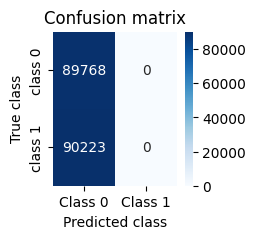

-----------------------------------------------
Epoch 18
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


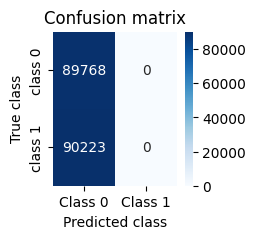

-----------------------------------------------
Epoch 19
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


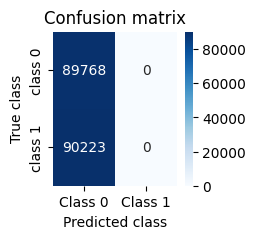

-----------------------------------------------
Epoch 20
-----------------------------------------------
Train loss 0.6931474804627882, Valid loss 0.6931474804802069, Accuracy 49.87360479135068


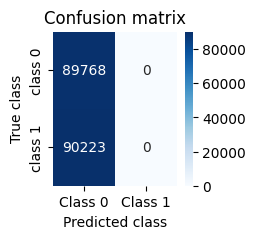

DONE!!!!!


In [36]:
train_losses = []
val_losses = []
accuracies_test = []

def train(model, loss_fn, optimizer, dataloader):
    model.train()
    total_loss = 0
    size = len(dataloader.dataset)  # Total number of samples
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * x.size(0)  # Accumulate total loss properly
    
    return total_loss / size  # Normalize by total number of samples

def test(model, loss_fn, dataloader):
    model.eval()
    test_loss, correct = 0, 0
    size = len(dataloader.dataset)  # Define size correctly
    conf_matrix = np.zeros((2,2), dtype=int)
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item() * x.size(0)  # Scale loss correctly
            correct += (pred.argmax(1) == y).sum().item()
            
            pred_class = pred.argmax(1)
            true_class = y

            for p, t in zip(pred_class, true_class):
                conf_matrix[t.item(), p.item()] += 1
    
    test_loss /= size  # Normalize by total samples
    correct = 100 * correct / size  # Convert to percentage
    
    return test_loss, correct, conf_matrix

for y in range(num_epochs):
    print(f'-----------------------------------------------\nEpoch {y+1}\n-----------------------------------------------')
    train_loss = train(model, criterion, optimizer, train_dataloader)
    val_loss, accuracy_test, conf_matrix = test(model, criterion, val_dataloader)
    print(f'Train loss {train_loss}, Valid loss {val_loss}, Accuracy {accuracy_test}')

    plt.figure(figsize = (2,2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['class 0','class 1'])
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.title('Confusion matrix')
    plt.show()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies_test.append(accuracy_test)

print("DONE!!!!!")

In [ ]:
# X_test_encoded = torch.tensor(list(test_data['indexed_flanking_seq'].values), dtype = torch.long)
# test_dataset = TensorDataset(X_test_encoded)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# random_seq_encoded = torch.tensor(list(random_sequences['indexed_flanking_seq'].values), dtype = torch.long)
# random_dataset = TensorDataset(random_seq_encoded)
# random_datatloader = DataLoader(random_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize a list to store encoded features
encoded_features_list = []

# Disable gradient calculation for inference
with torch.no_grad():
    for batch in test_dataloader:
        # Extract input sequences from the batch
        input_sequence = batch[0].long().to(device)  # Replace 'sequence' with the actual key in your dataset

        # Pass input to the encoder
        encoded_features = autoencoder.encode(input_sequence).to(device)

        # Append encoded features to the list
        encoded_features_list.append(encoded_features)

# Concatenate all encoded features into a single tensor
encoded_features_tensor = torch.cat(encoded_features_list, dim=0)

In [ ]:
encoded_features_tensor = encoded_features_tensor.cpu()
for i in range(encoded_features_tensor.shape[1]):  # Loop over each latent dimension
    test_data[f'encoded_feature_{i + 1}'] = encoded_features_tensor[:, i]
    #X_val[f'encoded_feature_{i + 1}'] = encoded_features_tensor[:, i]
    #X_valid[f'encoded_feature_{i + 1}'] = encoded_features_tensor[:, i]

In [ ]:
test_data.to_csv('test_data_latent.csv', index=False)

In [ ]:
encoded_features_tensor = encoded_features_tensor[:22000]

In [ ]:
encoded_features_tensor.shape

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
#encoded_features_channels_sequence = np.median(encoded_features_np, axis=1)
dbscan_labels = dbscan.fit_predict(encoded_features_tensor)
print("Кластеры:", np.unique(dbscan_labels))
print("Количество кластеров:", len(np.unique(dbscan_labels)))
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

if len(np.unique(dbscan_labels)) > 1:
    sil_score = silhouette_score(encoded_features_tensor, dbscan_labels)
    print(f"Silhouette Score: {sil_score:.2f}")
else:
    print("Недостаточно кластеров для вычисления Silhouette Score.")

# Уменьшение размерности до 2D для визуализации
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(encoded_features_tensor)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.title("Результаты кластеризации DBSCAN")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.show()

In [ ]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric='sqeuclidean')
hdbscan_labels = hdbscan_clusterer.fit_predict(encoded_features_tensor)

if len(np.unique(hdbscan_labels)) > 1:
    sil_score = silhouette_score(encoded_features_tensor, hdbscan_labels)
    print(f"Silhouette Score: {sil_score:.2f}")
else:
    print("Недостаточно кластеров для вычисления Silhouette Score.")


# Вывод результатов
print("Кластеры:", np.unique(hdbscan_labels))
print("Количество кластеров:", len(np.unique(hdbscan_labels)))
print("Шумовые точки (помечены -1):", np.sum(hdbscan_labels == -1))

# Уменьшение размерности до *D для визуализации
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(encoded_features_tensor)

# Визуализация 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced_features[:, 0], 
    reduced_features[:, 1], 
    reduced_features[:, 2], 
    c=hdbscan_labels, 
    cmap='viridis',
    marker='o',
    alpha=0.6
)

ax.set_title("Результаты кластеризации HDBSCAN в 3D")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.set_zlabel("Компонента 3")
fig.colorbar(scatter, label="Кластеры")

output_path = "visualization_3D.png" 
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
!pip install leidenalg

In [ ]:
pip install umap-learn

In [ ]:
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity
import igraph as ig
from leidenalg import find_partition
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from leidenalg import ModularityVertexPartition
from leidenalg import RBConfigurationVertexPartition, find_partition
import plotly.express as px
import umap
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize

In [ ]:
# Применяем UMAP к латентным представлениям
umap_reducer = umap.UMAP(n_neighbors=495, min_dist=0.2, n_components=2, random_state=42)
umap_latent = umap_reducer.fit_transform(encoded_features_tensor)

# 1. Construct the k-NN graph
knn_graph = kneighbors_graph(umap_latent, n_neighbors=495, mode='connectivity', include_self=False)

# 2. Build a similarity matrix (cosine similarity as an example)
similarity_matrix = cosine_similarity(umap_latent)

# Нормализация матрицы сходства
#similarity_matrix = (similarity_matrix + 1) / 2

# from scipy.spatial.distance import cdist
# manhattan_distance_matrix = cdist(umap_latent, umap_latent, metric='cityblock')
# manhattan_similarity = 1 / (1 + manhattan_distance_matrix)  # Преобразование расстояния в сходство

# sources, targets = knn_graph.nonzero()
# weights = manhattan_similarity[sources, targets]

# Convert similarity matrix into graph format for Leiden
sources, targets = knn_graph.nonzero()
weights = similarity_matrix[sources, targets]
weights = np.maximum(weights, 0) 
edges = list(zip(sources, targets))
g = ig.Graph(edges=edges, directed=False)

# 3. Run the Leiden algorithm
partition = find_partition(
    g,
    partition_type=RBConfigurationVertexPartition,
    weights=weights,
    resolution_parameter=6.5  # Higher resolution for more clusters
)

# Extract cluster labels
leiden_clusters = np.array(partition.membership)

print("Количество кластеров:", len(np.unique(leiden_clusters)))

if len(np.unique(leiden_clusters)) > 1:
    sil_score = silhouette_score(umap_latent, leiden_clusters)
    print(f"Silhouette Score: {sil_score:.2f}")
else:
    print("Недостаточно кластеров для вычисления Silhouette Score.")


# 4. Visualize the Leiden clusters
# Perform PCA for 2D visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(umap_latent)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=leiden_clusters, cmap='seismic', s=10, alpha=0.8)
plt.colorbar(scatter, label="Leiden Clusters")
plt.title("Leiden Clustering on Latent Representations")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Визуализация результатов UMAP
plt.figure(figsize=(10, 6))
scatter = plt.scatter(umap_latent[:, 0], umap_latent[:, 1], c=leiden_clusters, cmap='coolwarm', s=10, alpha=0.8)
plt.colorbar(scatter, label="Leiden Clusters")
plt.title("Leiden Clustering with UMAP")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Создадим DataFrame с координатами для визуализации и кластерами
pca_df = pd.DataFrame(latent_2d, columns=["PC1", "PC2"])
pca_df["Leiden Clusters"] = leiden_clusters

# Визуализация с Plotly для PCA
fig_pca = px.scatter(pca_df, x="PC1", y="PC2", color="Leiden Clusters", 
                     title="Leiden Clustering on Latent Representations (PCA)", 
                     color_continuous_scale='blackbody', 
                     labels={"Leiden Clusters": "Leiden Clusters"})
fig_pca.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                     selector=dict(mode='markers'))

fig_pca.show()

# Визуализация с Plotly для UMAP
umap_df = pd.DataFrame(umap_latent, columns=["UMAP1", "UMAP2"])
umap_df["Leiden Clusters"] = leiden_clusters

fig_umap = px.scatter(umap_df, x="UMAP1", y="UMAP2", color="Leiden Clusters", 
                      title="Leiden Clustering with UMAP", 
                      color_continuous_scale='algae',
                      labels={"Leiden Clusters": "Leiden Clusters"})
fig_umap.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                      selector=dict(mode='markers'))

fig_umap.show()
# 'aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
#              'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
#              'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
#              'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
#              'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
#              'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
#              'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
#              'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
#              'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
#              'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
#              'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
#              'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
#              'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
#              'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
#              'ylorrd'

In [ ]:
# Соотносим выданные кластеры с изначальными тестовыми данными
test_data["leiden_cluster"] = leiden_clusters
test_data[test_data["leiden_cluster"] == 1]

In [ ]:
filtered_pheno

In [ ]:
print(classification["PRIMARY_HISTOLOGY"].value_counts())

In [ ]:
# # 1. Фильтруем ID из test_data, относящиеся к кластеру 1
# cluster_1_ids = test_data.loc[test_data["leiden_cluster"] == 0, "ID"]

# # 2. Выбираем соответствующие ID в pheno
# pheno_filtered = pheno[pheno["GENOMIC_MUTATION_ID"].isin(cluster_1_ids)]

# # 3. Соотносим выбранные ID с class
# class_filtered = classification[classification["COSMIC_PHENOTYPE_ID"].isin(pheno_filtered["COSMIC_PHENOTYPE_ID"])]

# # 4. Выводим статистику по колонке histology
# histology_counts = class_filtered["PRIMARY_HISTOLOGY"].value_counts()

# # 5. Выводим результат
# print(histology_counts)


In [ ]:
# Фильтруем ID для первого кластера
cluster_1_ids = test_data.loc[test_data["leiden_cluster"] == 39, "ID"]
pheno_filtered_1 = pheno[pheno["GENOMIC_MUTATION_ID"].isin(cluster_1_ids)]
class_filtered_1 = classification[classification["COSMIC_PHENOTYPE_ID"].isin(pheno_filtered_1["COSMIC_PHENOTYPE_ID"])]
histology_counts_1 = class_filtered_1["PRIMARY_HISTOLOGY"].value_counts()

# Фильтруем ID для второго кластера
cluster_2_ids = test_data.loc[test_data["leiden_cluster"] == 4, "ID"]
pheno_filtered_2 = pheno[pheno["GENOMIC_MUTATION_ID"].isin(cluster_2_ids)]
class_filtered_2 = classification[classification["COSMIC_PHENOTYPE_ID"].isin(pheno_filtered_2["COSMIC_PHENOTYPE_ID"])]
histology_counts_2 = class_filtered_2["PRIMARY_HISTOLOGY"].value_counts()

# Фильтруем ID для второго кластера
cluster_3_ids = test_data.loc[test_data["leiden_cluster"] == 3, "ID"]
pheno_filtered_3 = pheno[pheno["GENOMIC_MUTATION_ID"].isin(cluster_3_ids)]
class_filtered_3 = classification[classification["COSMIC_PHENOTYPE_ID"].isin(pheno_filtered_3["COSMIC_PHENOTYPE_ID"])]
histology_counts_3 = class_filtered_3["PRIMARY_HISTOLOGY"].value_counts()

# Фильтруем ID для второго кластера
cluster_4_ids = test_data.loc[test_data["leiden_cluster"] == 6, "ID"]
pheno_filtered_4 = pheno[pheno["GENOMIC_MUTATION_ID"].isin(cluster_4_ids)]
class_filtered_4 = classification[classification["COSMIC_PHENOTYPE_ID"].isin(pheno_filtered_4["COSMIC_PHENOTYPE_ID"])]
histology_counts_4 = class_filtered_4["PRIMARY_HISTOLOGY"].value_counts()

# Объединяем по индексам (PRIMARY_SITE)
histology_comparison = pd.concat([histology_counts_1, histology_counts_2, histology_counts_3, histology_counts_4], axis=1, keys=["Cluster_1", "Cluster_2", "Cluster_3", "Cluster_4"])

# Заполняем пропущенные значения нулями
histology_comparison = histology_comparison.fillna(0).astype(int)

pd.set_option("display.expand_frame_repr", False)  # Отключает перенос строк
pd.set_option("display.width", 200)  # Устанавливает максимальную ширину строки

# Выводим результат
print(histology_comparison)


In [ ]:
cluster_1 = test_data.loc[test_data["leiden_cluster"] == 39, "PRIMARY_HISTOLOGY"].value_counts()
cluster_2 = test_data.loc[test_data["leiden_cluster"] == 4, "PRIMARY_HISTOLOGY"].value_counts()
cluster_3 = test_data.loc[test_data["leiden_cluster"] == 6, "PRIMARY_HISTOLOGY"].value_counts()
cluster_4 = test_data.loc[test_data["leiden_cluster"] == 3, "PRIMARY_HISTOLOGY"].value_counts()
# Объединяем данные в одну таблицу по индексу PRIMARY_HISTOLOGY
histology_comparison = pd.concat([cluster_1, cluster_2, cluster_3, cluster_4], axis=1)

# Переименовываем столбцы для каждого кластера
histology_comparison.columns = ["Cluster_1", "Cluster_2", "Cluster_3", "Cluster_4"]

# Заполняем пропущенные значения нулями
histology_comparison = histology_comparison.fillna(0).astype(int)

# Выводим результат
print(histology_comparison)